# SGD variance, learning-rate schedules, and batch-size strategies

In this notebook we study optimization dynamics for a
regularized logistic regression problem solved by stochastic gradient descent (SGD).

We want to understand how the variance of the stochastic gradient estimate impacts its convergence, and how to improve it. To do that, we focus on the effect of two hyperparameters:
 1. batch size
 2. learning-rate

We will see how a fixed batch size impacts the convergence and show the advantages of an increasing batch size. In the same way, we will study the effect of decreasing learning-rates.




In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# Configuration: use FAST_MODE for quick testing, otherwise production runs
FAST_MODE = True
if FAST_MODE:
    EPOCHS = 800     # Quick runs; use 5000 for high-quality plots
else:
    EPOCHS = 5000

# Hyperparameters
ALPHA0 = 1e-3          # Initial learning rate
GAMMA = 1e-4        # L2 regularization strength


## 2. Synthetic dataset with ill-conditioned features

We generate features $X \in \mathbb{R}^{m \times n}$ with logarithmically spaced scaling
(ranging from 1 to 1000 across dimensions). This creates strong anisotropy that makes
optimization behavior more interesting and closer to realistic ill-conditioned problems.

In [2]:
def make_synthetic_logistic(m=5000, n=40, seed=0):
    """Generate ill-conditioned logistic regression dataset."""
    rng = np.random.default_rng(seed)

    # Features with logarithmically spaced scaling (creates anisotropy)
    X = rng.normal(size=(m, n))
    scales = np.logspace(0, 3, n)   # Scale ranges from 1 to 1000
    X = X * scales

    # Generate binary labels from logistic model
    w_true = rng.normal(size=n)
    logits = X @ w_true
    p = 1.0 / (1.0 + np.exp(-logits))
    y = rng.binomial(1, p)

    return X.astype(np.float64), y.astype(np.int32), w_true


X, y, w_true = make_synthetic_logistic(m=6000, n=20, seed=0)
print("X shape:", X.shape, "| y shape:", y.shape)
print("y mean (class balance):", y.mean())

X shape: (6000, 20) | y shape: (6000,)
y mean (class balance): 0.49266666666666664


/var/folders/pv/7xq94jdd4d51wrjpm4h32qj00000gn/T/ipykernel_7111/3834632955.py:13: RuntimeWarning: overflow encountered in exp
  p = 1.0 / (1.0 + np.exp(-logits))


## 3. Objective function: regularized logistic regression

We minimize:
$$f(\theta) = \frac{1}{n}\sum_{i=1}^n \ell( x_i^T \theta, y_i) + \frac{\gamma}{2}\|\theta\|^2,$$
where $\ell$ is the logistic loss:
$$
\ell(z, y)
  = -\, y \log z
    - (1 - y)\log(1 - z)
$$
and $\gamma > 0$ is a regularization parameter. 

We implement
the  sigmoid function, the logistic loss, its gradient and its Hessian.


In [3]:
def sigmoid(z):
    """Numerically stable sigmoid to avoid overflow."""
    z = z.astype(np.float64, copy=False)
    out = np.empty_like(z, dtype=np.float64)
    # Handle positive and negative values separately for stability
    pos = (z >= 0)
    neg = ~pos
    out[pos] = 1.0 / (1.0 + np.exp(-z[pos]))
    ez = np.exp(z[neg])
    out[neg] = ez / (1.0 + ez)
    return out

def logloss(w, X, y, gamma=1e-4):
    """Logistic loss with L2 regularization."""
    z = X @ w
    p = sigmoid(z)
    eps = 1e-12
    # Binary cross-entropy loss
    loss = -np.mean(y * np.log(p+eps) + (1-y)*np.log(1-p+eps))
    loss += 0.5 * gamma * np.sum(w**2)  # Add L2 penalty
    return float(loss)

def grad_logloss(w, X, y, gamma=1e-4):
    """Gradient of logistic loss (used by SGD)."""
    z = X @ w
    p = sigmoid(z)
    grad = (X.T @ (p - y)) / X.shape[0]
    grad += gamma * w  # Gradient of L2 penalty
    return grad.astype(np.float64)

def hess_logloss_full(w, X, y, gamma=1e-4, damping=1e-8):
    n, d = X.shape
    z = X @ w
    p = sigmoid(z)
    w_diag = p*(1-p)
    WX = X * w_diag[:,None]
    H = (X.T @ WX) / n

    reg = np.zeros((d,d))
    reg[1:,1:] = gamma*np.eye(d-1)
    H = H + reg + damping*np.eye(d)
    return H



## 4. Reference optimum $f(\theta^*)$
We will measure progress in the optimization through suboptimality:  $f(\theta_k) - f(\theta^*)$.
A reliable reference value $f(\theta^*)$ can be computed via Newton's method. To save computational time we provide here
 a precomputed value.
The Newton solution method is also provided and can be optionally run.  

In [ ]:
# Precomputed optimal loss value for suboptimality measurements
f_opt = 1.101595433540e-03
print("Using precomputed f_opt =", f_opt)


def newton_solve_opt(X, y, lam=1e-4, tol=1e-10, max_iter=50):
    """Compute optimal value via Newton's method (expensive, for reference)."""
    d = X.shape[1]
    w = np.zeros(d)

    for it in range(max_iter):
        g = grad_logloss(w, X, y, lam)
        ng = np.linalg.norm(g)
        if ng < tol:
            print(f"[Newton] Converged in {it} iterations | ||g||={ng:.2e}")
            break

        # Newton step: w = w - H^{-1} * g
        H = hess_logloss_full(w, X, y, lam)
        step = np.linalg.solve(H, g)
        w = w - step

    f_star = logloss(w, X, y, lam)
    print(f"[Newton] f* = {f_star:.12e}")
    return w, f_star


# Uncomment to recompute f_opt (slow; needed if data or regularization changes)
# w_star, f_opt = newton_solve_opt(X, y, gamma=GAMMA)

Using precomputed f_opt = 0.00110159543354


## 5. Polynomial learning rate scheduler

To reduce noise and improve convergence in later stages, we consider an adaptive learning rate strategy. We implement a polynomial decay schedule:

$$\alpha_k = \frac{\alpha_0}{(1 + \gamma k)^p},$$

where $\alpha_0$ is the initial learning rate, $\gamma$ controls the decay rate, $k$ is the epoch, and $p$ is the power (typically 1).

This schedule starts with a larger step size for exploration and gradually decreases it, allowing the optimizer to make fine adjustments near the optimum without overshooting.

In [5]:
def poly_scheduler(epoch, alpha0, decay=5e-3, power=1):
    return alpha0 / ((1 + decay * epoch) ** power)

## 6. SGD runner (fixed batch size)

We implement full-epoch SGD with shuffling, mini-batch updates, and per-epoch tracking
of loss, suboptimality, and direction variance.

Direction variance is a measure  of SGD noise. Within each epoch, SGD produces a sequence of update directions $d_1, \dots, d_M$
(one per mini-batch). We measure how noisy the minibatch directions are  by the following dimensionless indicator :

$$\text{dir}_{\text{var}} = \frac{\mathbb{E}\|d_i - \bar{d}\|^2}{\|\bar{d}\|^2}, \quad \bar{d} = \mathbb{E}[d_i].$$



When this indicator is small, it means that mini-batch directions agree and the stochastic noise is low. On the contrary, a large value indicates a noisy dynamic, with highly variable directions.

In [17]:
def run_sgd(
    X, y, gamma=1e-4,
    epochs=300, batch_size=8,
    alpha0=1e-3, scheduler=None,
    seed=0, f_opt=None
):
    n, d = X.shape
    rng = np.random.default_rng(seed)
    w = np.zeros(d)

    hist_loss, hist_subopt, hist_var, hist_epoch = [], [], [], []

    for ep in range(epochs):
        lr = alpha0 if scheduler is None else scheduler(ep, alpha0)

        idx = rng.permutation(n)
        Xs, ys = X[idx], y[idx]

        dirs = []
        for start in range(0, n, batch_size):
            end = min(start + batch_size, n)
            g = grad_logloss(w, Xs[start:end], ys[start:end], gamma)
            d_step = -lr * g
            dirs.append(d_step)
            w = w + d_step

        f = logloss(w, X, y, gamma)
        hist_loss.append(f)
        hist_subopt.append(f - f_opt)
        hist_epoch.append(ep)

        D = np.stack(dirs, axis=0)
        mean_d = D.mean(axis=0)
        diff = D - mean_d
        num = np.mean(np.sum(diff * diff, axis=1))
        denom = np.linalg.norm(mean_d) ** 2 + 1e-12
        hist_var.append(num / denom)

    return {
        "epoch": np.array(hist_epoch),
        "loss": np.array(hist_loss),
        "subopt": np.array(hist_subopt),
        "dir_var": np.array(hist_var),
    }

# 7. Effect of the batch size
We run SGD with constant batch sizes 4, 16 and 1024. Here the learning rate is a fixed small constant.

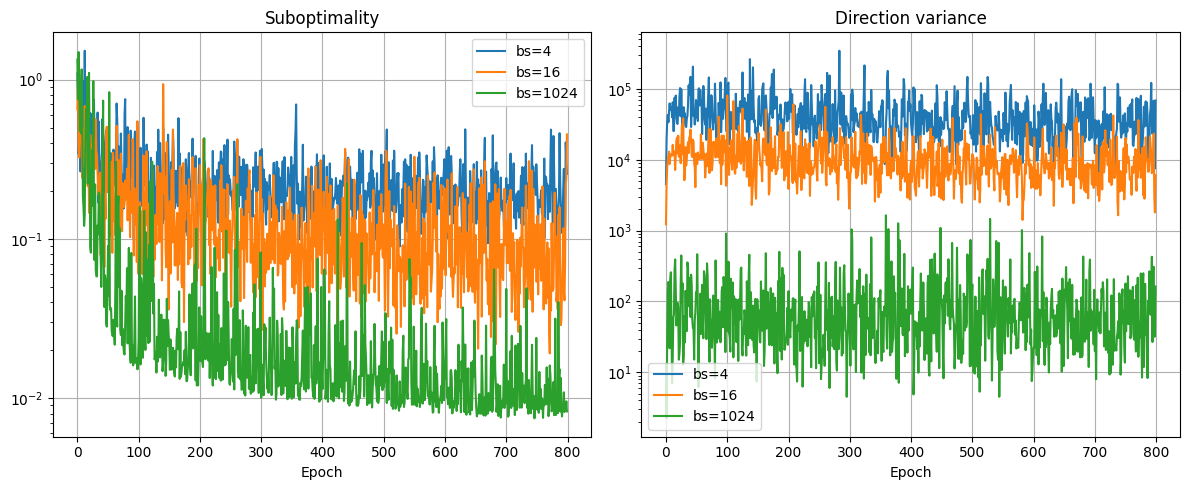

In [21]:
bs_list = [4, 16, 1024]
histories_B = {}

for bs in bs_list:
    h = run_sgd(
        X, y, gamma=GAMMA,
        epochs=EPOCHS, batch_size=bs,
        alpha0=ALPHA0, scheduler=None,
        seed=0, f_opt=f_opt
    )
    histories_B[bs] = h

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
for bs in bs_list:
    plt.semilogy(histories_B[bs]["epoch"], histories_B[bs]["subopt"], label=f"bs={bs}")
plt.title("Suboptimality")
plt.xlabel("Epoch")
plt.grid(True); plt.legend()

plt.subplot(1,2,2)
for bs in bs_list:
    plt.semilogy(histories_B[bs]["epoch"], histories_B[bs]["dir_var"], label=f"bs={bs}")
plt.title("Direction variance")
plt.xlabel("Epoch")
plt.grid(True); plt.legend()

plt.tight_layout()
plt.show()

# Experiment 2: progressive batch size

A common strategy to progressively decrease variance is to start with small batches (cheap, noisy updates)
and gradually increase the batch size (more accurate but more costly updates).

We implement a linear schedule from `bs_start` to `bs_end`.

We compare a fixed small batch size with the progressive batch size strategy.

In [22]:
def run_sgd_progressive(
    X, y, gamma=1e-4,
    epochs=300,
    bs_start=8, bs_end=512,
    alpha0=1e-3, seed=0, f_opt=None
):
    n, d = X.shape
    rng = np.random.default_rng(seed)
    w = np.zeros(d)

    hist_loss, hist_subopt, hist_var, hist_epoch = [], [], [], []

    for ep in range(epochs):
        frac = ep / (epochs - 1) if epochs > 1 else 1.0
        bs = int(bs_start + frac * (bs_end - bs_start))
        bs = max(1, min(bs, n))

        idx = rng.permutation(n)
        Xs, ys = X[idx], y[idx]

        dirs = []
        for start in range(0, n, bs):
            end = min(start + bs, n)
            g = grad_logloss(w, Xs[start:end], ys[start:end], gamma)
            d_step = -alpha0 * g
            dirs.append(d_step)
            w = w + d_step

        f = logloss(w, X, y, gamma)
        hist_loss.append(f)
        hist_subopt.append(f - f_opt)
        hist_epoch.append(ep)

        D = np.stack(dirs, axis=0)
        mean_d = D.mean(axis=0)
        diff = D - mean_d
        num = np.mean(np.sum(diff * diff, axis=1))
        denom = np.linalg.norm(mean_d) ** 2 + 1e-12
        hist_var.append(num / denom)

    return {
        "epoch": np.array(hist_epoch),
        "loss": np.array(hist_loss),
        "subopt": np.array(hist_subopt),
        "dir_var": np.array(hist_var),
    }

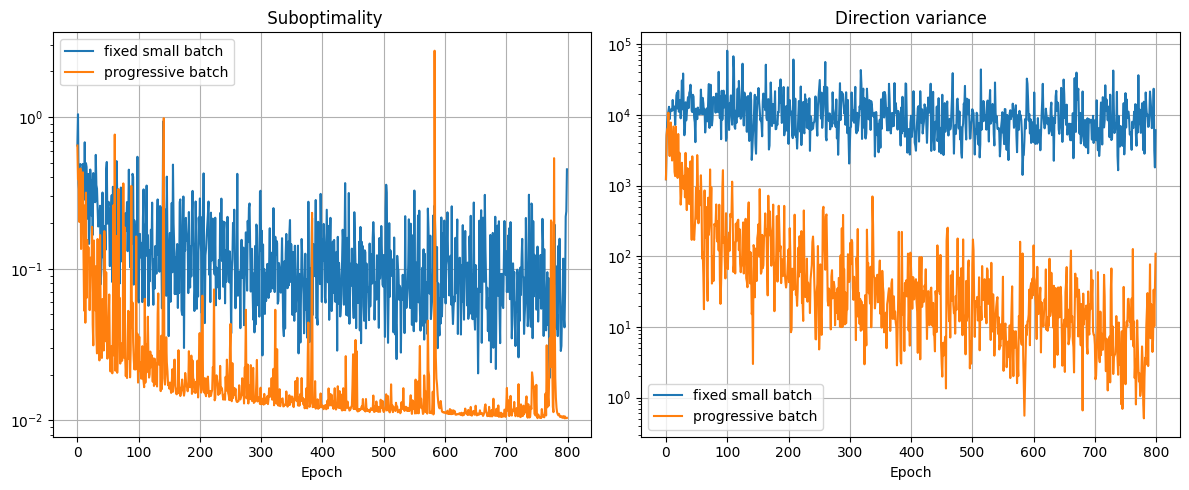

In [ ]:
bs_start, bs_end = 16, 2048

hist_fixedC = run_sgd(
    X, y, gamma=GAMMA,
    epochs=EPOCHS, batch_size=bs_start,
    alpha0=ALPHA0, scheduler=None,
    seed=0, f_opt=f_opt
)

hist_prog = run_sgd_progressive(
    X, y, gamma=GAMMA,
    epochs=EPOCHS,
    bs_start=bs_start, bs_end=bs_end,
    alpha0=ALPHA0,
    seed=0, f_opt=f_opt
)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.semilogy(hist_fixedC["epoch"], hist_fixedC["subopt"], label="Fixed small batch")
plt.semilogy(hist_prog["epoch"], hist_prog["subopt"], label="Progressive batch")
plt.title(" Suboptimality")
plt.xlabel("Epoch")
plt.grid(True); plt.legend()

plt.subplot(1,2,2)
plt.semilogy(hist_fixedC["epoch"], hist_fixedC["dir_var"], label="Fixed small batch")
plt.semilogy(hist_prog["epoch"], hist_prog["dir_var"], label="Progressive batch")
plt.title("Direction variance")
plt.xlabel("Epoch")
plt.grid(True); plt.legend()

plt.tight_layout()
plt.show()

# 8. Effect of the learning rate

Here we consider a fixed batch size and we study the effect of the learning rate, by dynamically decreasing it thanks to our polynomial scheduler.
We compare the scheduler with a constant learning-rate.

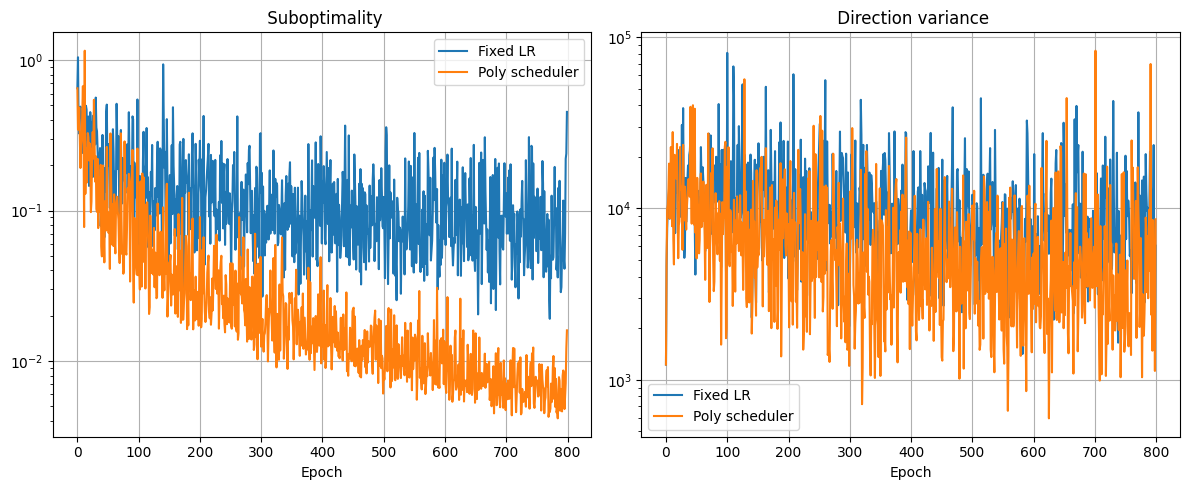

In [26]:
bsA = 16

hist_fixed = run_sgd(
    X, y, gamma=GAMMA,
    epochs=EPOCHS, batch_size=bsA,
    alpha0=ALPHA0, scheduler=None,
    seed=0, f_opt=f_opt
)

hist_sched = run_sgd(
    X, y, gamma=GAMMA,
    epochs=EPOCHS, batch_size=bsA,
    alpha0=ALPHA0,
    scheduler=lambda ep, e0: poly_scheduler(ep, e0, decay=0.02),
    seed=0, f_opt=f_opt
)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.semilogy(hist_fixed["epoch"], hist_fixed["subopt"], label="Fixed LR")
plt.semilogy(hist_sched["epoch"], hist_sched["subopt"], label="Poly scheduler")
plt.title(" Suboptimality")
plt.xlabel("Epoch")
plt.grid(True); plt.legend()

plt.subplot(1,2,2)
plt.semilogy(hist_fixed["epoch"], hist_fixed["dir_var"], label="Fixed LR")
plt.semilogy(hist_sched["epoch"], hist_sched["dir_var"], label="Poly scheduler")
plt.title(" Direction variance")
plt.xlabel("Epoch")
plt.grid(True); plt.legend()

plt.tight_layout()
plt.show()

# Discussion and Takeaways

These experiments highlight key trade-offs in stochastic optimization:

**Batch size** controls the noise-stability trade-off. Small batches enable cheap, exploratory updates
but accumulate noisy gradient estimates. Large batches stabilize but reduce the effective number of updates.

 **Progressive batching** attempts to balance both regimes: small batches for exploration, large batches for refinement.
This strategy is now standard in large-scale deep learning to maximize computational efficiency.

**Learning-rate decay** smooths out noisy directions over time, improving final convergence at the cost
of slower initial progress. Fixed rates maintain agility but may struggle in late stages.

